# Social Interaction Ethogram Built

Create a panda structure with all relevant parameters for ethogram construction. 

Parameters are based definitions of in de Chaumon et al. Nature 2012. 'Computerized video analysis of social interactions in mice'.

''' May 25th 2021'''


In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
import csv
from collections import namedtuple
from sympy import *


In [105]:
def distance(point1,point2):
    xdiff = point1[0] - point2[0]
    ydiff = point1[1] - point2[1]
    dist = np.sqrt(xdiff*xdiff + ydiff*ydiff)
    return dist

def direction(point1,point2):
    x_diff = point1[0] - point2[0]
    y_diff = point1[1] - point2[1]
    direction = np.array([x_diff , y_diff])
    return direction

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [106]:
def get_tracking_parameters(tracking = None, body_parts = None):
    
    '''
    This function will receive the final positions of body parts (after stimation of nose)
    It will have N*2 entraces, where N is the number of body parts per animal
    For starting point we will use the nose of the tracker and then refine it to another nose position
    using other information (as drive position, maybenose, accelerometer, etc).
    '''
    
    N = int(np.min(tracking.shape)/6)
    tpoints = tracking.shape[0]
    
    #separate animals tracking
    tracking1 = np.array([tracking[:,[i*3,i*3+1]] for i in range(N)])
    tracking2 = np.array([tracking[:,[i*3+N*3,i*3+1+N*3]] for i in range(N)])
    
    print(tracking1.shape)
    
    #compute center of mass taking into account all bodyparts
    cm1 =  np.mean(tracking1,axis=0)
    cm2 =  np.mean(tracking2,axis=0)
    
    #compute speed
    v1 = np.array([np.diff(cm1[:,i], prepend = 0) for i in range(2)]).T
    speed1 = np.linalg.norm(v1,axis = 0)
    v2 = np.array([np.diff(cm2[:,i], prepend = 0) for i in range(2)]).T
    speed2 = np.linalg.norm(v2,axis = 0)
    
    #compute head direction
    hd1= np.array([direction(tracking1[3,i,:],tracking1[0,i,:]) for i in range(tpoints)])
    hd2= np.array([direction(tracking2[3,i,:],tracking1[0,i,:]) for i in range(tpoints)])

    #compute body direction
    bd1= np.array([direction(tracking1[4,i,:],tracking1[3,i,:]) for i in range(tpoints)])
    bd2= np.array([direction(tracking2[4,i,:],tracking1[3,i,:]) for i in range(tpoints)])

    parameters = {'cm1' : cm1 , 'cm2': cm2, 'head_direction1': hd1 , 'head_direction2': hd2 , 
                  'speed1' : speed1, 'speed2': speed2 ,
                  'body_direction1': bd1, 'body_direction2': bd2}

    return parameters(cm1,cm2,head_direction1,head_direction2,speed1,speed2,body_direction1,body_direction2)

In [107]:
import random

def generate_theta(a, b):
    u = random.random() / 4.0
    theta = np.arctan(b/a * np.tan(2*np.pi*u))
    v = random.random()
    if v < 0.25:
        return theta
    elif v < 0.5:
        return np.pi - theta
    elif v < 0.75:
        return np.pi + theta
    else:
        return -theta

def radius(a, b, theta):
    return a * b / np.sqrt((b*np.cos(theta))**2 + (a*np.sin(theta))**2)

def random_point(a, b ,center, alpha):
    random_theta = generate_theta(a, b)
    max_radius = radius(a, b, random_theta)
    random_radius = max_radius * np.sqrt(random.random())

    return np.array([
        random_radius * np.cos(random_theta + alpha) + center[0],
        random_radius * np.sin(random_theta+ alpha) + center[1]
    ])

In [154]:
def distance_between_ellipse(ellipse1, ellipse2, npoints):
    
    #define ellipse parameters for random generator
    a1 = ellipse1.axis1
    b1 = ellipse1.axis2
    center1 = ellipse1.center
    alpha1 = ellipse1.angle

    a2 = ellipse2.axis1
    b2 = ellipse2.axis2
    center2 = ellipse2.center
    alpha2 = ellipse2.angle

    #generate random points inside each ellipse
    points1 = np.array([random_point(a1, b1, center1, alpha1) for _ in range(npoints)])
    points2 = np.array([random_point(a2, b2, center2, alpha2) for _ in range(npoints)])
    
    distance_vector = [distance(x,y) for x in points1 for y in points2]

    min_distance = min(distance_vector)
    
    return min_distance

def distance_ellipse_circle(ellipse,circle, npoints):
    
    #define ellipse parameters for random generator
    a1 = ellipse.axis1
    b1 = ellipse.axis2
    center1 = ellipse.center
    alpha1 = ellipse.angle

    r = circle.radius
    center2 = circle.center
    
    #generate random points inside each ellipse
    points1 = np.array([random_point(a1, b1, center1, alpha1) for _ in range(npoints)])
    points2 = np.array([random_point(r, r, center2, 0) for _ in range(npoints)])
    
    distance_vector = [distance(x,y) for x in points1 for y in points2]

    min_distance = min(distance_vector)
    
    return min_distance

def distance_between_circle(circle1, circle2):
    
    #define circle1 parameters
    r1 = circle1.radius
    center1 = circle1.center

    #define circle2 parameters
    r2 = circle2.radius
    center2 = circle2.center

    center_distance = distance(center1,center2) 
    min_distance = 0
    if center_distance > (r1+r2):
        min_distance = center_distance - (r1+r2)
    
    return min_distance

In [151]:
from sklearn.linear_model import LinearRegression

def circle_center(point1,point2,point3):
    ### in construction
    '''
    Compute the center of the circle along the axis that is perpendicular
    to the ears and intersects nose positions
    input : point1 -> Nose position
            point2 -> RightEar position
            point3 -> LeftEar position
    return : C1 center of circle position
    '''
    
    point4 = (point3 + point2)/2
    C1 = (point1 + point4)/2
    
    return C1

def circle_model(point):
    ### in construction
    '''
    Compute the center of the circle 
    
    ans radius
    '''
    center = point
    #print(center.shape)
    #if point.shape[0]>1:
    #    center = np.mean(point,axis=1)
    radius = 3
    circle = namedtuple('circle',['center','radius'])
    
    return circle(center,radius)

def ellipse_model(points_set = None , axis_length = [0,0]):
    
    '''
    Compute center and axis lenght of the elipse along the the axis that optimal fits
    neck, com and tail positions.
    input : set of points with at least the next points information
            point1 -> Neck position
            point2 -> Center of mass position
            point3 -> tail position
    return : C center of elipsoide, angle of principal axis and axis1 and axis2 length of the elipsoide
    
    '''
    #compute line for principal axis of the elipsoide
    X = points_set[:,0]
    y = points_set[:,1]
    reg = LinearRegression().fit(X.reshape(-1,1), y.reshape(-1,1))

    #compute center of the elipsoude
    C_x = np.mean(points_set[:,0])
    C_y = float(reg.predict(C_x.reshape(-1,1)))
    center = np.array([C_x,C_y])
    
    # compute angle of principal axis
    bias = reg.predict(np.array([0]).reshape(-1,1))
    angle =  float(np.arctan2(center[1] - bias , center[0]))
    
    #compute axis1 and axis2 length 
    axis1 = np.linalg.norm(points_set[-1,:]-points_set[0,:])/2  #big axis is variable
    axis2 = axis_length[1] #small axis is fixed
    
    #compute ellipse focus based on axis length and angle
    gamma = np.sqrt(abs(axis1**2 - axis2**2))
    focus1_x = C_x + gamma * np.cos(angle)
    focus1_y = C_y + gamma * np.sin(angle)
    focus1 = np.array([focus1_x,focus1_y])

    focus2_x = C_x - gamma * np.cos(angle)
    focus2_y = C_y - gamma * np.sin(angle)
    focus2 = np.array([focus2_x,focus2_y])
    
    elipse = namedtuple('elipse', ['reg', 'center', 'angle', 'axis1', 'axis2','focus1','focus2'])
    return elipse(reg, center , angle, axis1, axis2, focus1, focus2)

def mouse_shape_model(position = None):
    
    '''
    Create a model of a mouse based on ellipses that are constructud by taking into account body positions.
    '''
    #head model
    head_parts = position[[0,3],:]
    head_model = ellipse_model(points_set = head_parts,axis_length = [0,10])
    
    #body model
    body_parts = position[[3,4,5],:]
    body_model = ellipse_model(points_set = body_parts, axis_length = [0,20])
    
    #tail model
    tail_parts = position[5,:]
    tail_model = circle_model(tail_parts)

    shape = namedtuple('mouse_model', ['head', 'body', 'tail'])
    return shape(head_model , body_model, tail_model)

def mouse_temporal_model(tracking = None):

    shape_model = [mouse_shape_model(position = tracking[:,i,:]) for i in range(tracking.shape[1])]
    mouse_model = namedtuple('mouse_model', ['shape_model'])

    return mouse_model(shape_model)

In [176]:
def get_model_static_parameters(shape_model1 = None, shape_model2= None):
    
    '''
    This function will receive the mouse model and compute relevant STATIC parameters over the
    mouse ellipsoidal model.
    input -> shape_model1 : ellipsoidal/circular model for animal 1
             shape_model2 : ellipsoidal/circular model for animal 2
             
    output -> tupple with relevant parameters
    '''
    ## define body parts with model
    body1 = shape_model1.body
    body2 = shape_model2.body
    head1 = shape_model1.head
    head2 = shape_model2.head
    tail1 = shape_model1.tail
    tail2 = shape_model2.tail
        
    ## compute distances between different model body parts
    npoints = 200 # number of random samples for ellipsoide distance computation
    db1b2 = distance_between_ellipse(body1, body2, npoints)
    dh1h2 = distance_between_ellipse(head1, head2, npoints)
    dt1t2 = distance_between_circle(tail1,tail2)

    db1h2 = distance_between_ellipse(body1,head2, npoints)
    db1t2 = distance_ellipse_circle(body1,tail2,npoints)
    
    db2h1 = distance_between_ellipse(body2,head1, npoints)
    db2t1 = distance_ellipse_circle(body2,tail1, npoints)

    distance_parameters = namedtuple('distance_parameters', ['b1b2','b1h2','b1t2','b2h1','b2t1','h1h2','t1t2'])
    distance_parameters(db1b2,db1h2,db1t2,db2h1,db2t1,dh1h2,dt1t2)
    
    #compute head direction

    #compute body direction
    
    #parameters = namedtuple('parameters',['distance_parameters'])#, 'direction_parameters'])
    
    #return parameters(distance_parameters)#,direc_params)
    
    return distance_parameters(db1b2,db1h2,db1t2,db2h1,db2t1,dh1h2,dt1t2)


### Build a model and get parameters based on the tracking from DLC

In [14]:
## load tracking information
tracking_path = Path('/home/melisa/Documents/social_interaction/')
tracking_path.exists()
input_file_name = 'raw120sDLC_resnet50_social_interaction_labelmei19shuffle1_694000.csv'
input_file_path = tracking_path / input_file_name
tracking_DFrame = pd.read_csv(input_file_path)

In [15]:
#tracking_DFrame

In [16]:
## get body parts from tracking fil
body_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
body_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]

In [17]:
# convert tracking pandas to numpy
tracking_DFrame = tracking_DFrame.iloc[2:]
tracking_DFrame = tracking_DFrame.astype(float)
tracking_data = tracking_DFrame.to_numpy()

In [18]:
# get parameters from tracking directly
body_tracking = tracking_data[:,1+5*3:];
parameters = get_tracking_parameters(tracking = body_tracking);
#df = pd.DataFrame(list(parameters.items()),columns = ['cm1','cm2','head_direction1','head_direction2','speed1','speed2','body_direction1','body_directiond2']) 


(6, 3600, 2)


In [19]:
## separate animals to build a model of mouse

tracking = body_tracking
N = int(np.min(tracking.shape)/6)
#separate animals tracking
tracking1 = np.array([tracking[:,[i*3,i*3+1]] for i in range(N)])
tracking2 = np.array([tracking[:,[i*3+N*3,i*3+1+N*3]] for i in range(N)])
    

In [152]:
## create mice model

model1 = mouse_temporal_model(tracking = tracking1)
model2 = mouse_temporal_model(tracking = tracking2)

In [183]:
frame_n = 1000
parameters = get_model_static_parameters(shape_model1 = model1.shape_model[frame_n], shape_model2= model2.shape_model[frame_n])

print(parameters.t1t2)

287.01731929770324


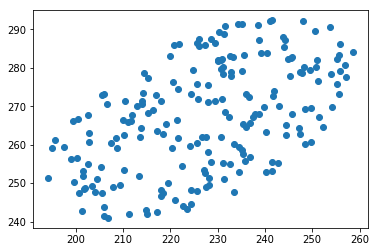

In [102]:
frame_n = 1000

## example of ellipsoide generation (random samplinf for distance computation)
a1 = model1.shape_model[frame_n].body.axis1
b1 = model1.shape_model[frame_n].body.axis2
center1 = model1.shape_model[frame_n].body.center
alpha1 = model1.shape_model[frame_n].body.angle

# a2 = model2.body[frame_n].axis1
# b2 = model2.body[frame_n].axis2
# center2 = model2.body[frame_n].center
# alpha2 = model2.body[frame_n].angle

points1 = np.array([random_point(a1, b1, center1, alpha1) for _ in range(200)])
#points2 = np.array([random_point(a2, b2, center2, alpha2) for _ in range(200)])

plt.scatter(points1[:,0], points1[:,1])
#plt.scatter(points2[:,0], points2[:,1])

#plt.xlim([-5,5])
#plt.ylim([-5,5])
plt.show()

In [32]:
# ## Solve the intersection problem using elipse formulas, lagrange multipliers and symbolic python

# x1, x2, y1, y2, l1, l2 = symbols('x1 x2 y1 y2 l1 l2')
# frame_n = 100

# a1 = model1.body[frame_n].axis2**2
# b1 = model1.body[frame_n].axis1**2
# c1 = 0
# d1 = -2*model1.body[0].axis2**2*model1.body[frame_n].center[0]
# e1 = -2*model1.body[0].axis2**2*model1.body[frame_n].center[1]
# f1 = a1* model1.body[frame_n].center[0]**2 + b1 * model1.body[frame_n].center[1]**2 - a1*b1


# a2 = model2.body[frame_n].axis2**2
# b2 = model2.body[frame_n].axis1**2
# c2 = 0
# d2 = -2*model2.body[0].axis2**2*model2.body[frame_n].center[0]
# e2 = -2*model2.body[0].axis2**2*model2.body[frame_n].center[1]
# f2 = a1* model2.body[frame_n].center[0]**2 + b1 * model2.body[frame_n].center[1]**2 - a1*b1

# solve([Eq(2*(x1-x2) + l1 *(2*a1*x1 + c1*y1 + d1),0),
#    Eq(2*(y1-y2) + l1 *(2*b1*y1 + d1*x1 + e1), 0),
#    Eq(2*(x2-x1) + l2 *(2*a2*x2 + c2*y2 + d2),0),
#    Eq(2*(y2-y2) + l2 *(2*b2*y2 + d2*x2 + e2), 0),
#    Eq(a1*x1**2+b1*y1**2+d1*x1+e1*y1+f1,0),
#    Eq(a2*x2**2+b2*y2**2+d2*x2+e2*y2+f2,0)], [x1,x2,y1,y2,l1,l2], simplify=False)

In [153]:
### Create a video with the model
import cv2
input_video_name = tracking_path / 'raw120s.mp4'
output_video = tracking_path / 'ellipse.avi'

cap = cv2.VideoCapture(str(input_video_name))
#cap.set(cv2.CAP_PROP_POS_FRAMES, frame_n)
output = cv2.VideoWriter(str(output_video),cv2.VideoWriter_fourcc(*'MJPG'),30,(700,700))

for frame_n in range(3600):
    
    r , frame = cap.read()    
    frame = np.zeros((700,700,3),dtype = 'uint8')
    
    p1 = (0, model1.shape_model[frame_n].body.reg.intercept_)
    p2 = (700, 700* model1.shape_model[frame_n].body.reg.coef_ + model1.shape_model[frame_n].body.reg.intercept_)
    cv2.line(frame, p1, p2 , color = (255,255,255));
    p1 = (0, model1.shape_model[frame_n].head.reg.intercept_)
    p2 = (700, 700* model1.shape_model[frame_n].head.reg.coef_ + model1.shape_model[frame_n].head.reg.intercept_)
    cv2.line(frame, p1, p2 , color = (255,255,255));
    
    p1 = (0, model2.shape_model[frame_n].body.reg.intercept_)
    p2 = (700, 700* model2.shape_model[frame_n].body.reg.coef_ + model2.shape_model[frame_n].body.reg.intercept_)
    cv2.line(frame, p1, p2 , color = (0,0,255));
    p1 = (0, model2.shape_model[frame_n].head.reg.intercept_)
    p2 = (700, 700* model2.shape_model[frame_n].head.reg.coef_ + model2.shape_model[frame_n].head.reg.intercept_)
    cv2.line(frame, p1, p2 , color = (0,0,255));

    
    center1 = model1.shape_model[frame_n].body.center.astype(int)
    center2 = model2.shape_model[frame_n].body.center.astype(int)
    
    #print(tuple(center1))
    #print((model1.body[frame_n].axis1.astype(int),model1.body[frame_n].axis2))

    cv2.circle(frame, tuple(center1), 10, color = (255,0,0), thickness = 1)
    cv2.ellipse(frame, tuple(center1),(model1.shape_model[frame_n].body.axis1.astype(int),
                                       model1.shape_model[frame_n].body.axis2) , math.degrees(model1.shape_model[frame_n].body.angle),
                0, 360, color = (0,0,255), thickness = 5);
    
    cv2.circle(frame, tuple(center2), 10, color = (255,0,0), thickness = 1)
    cv2.ellipse(frame, tuple(center2),(model2.shape_model[frame_n].body.axis1.astype(int),model2.shape_model[frame_n].body.axis2) ,
                math.degrees(model2.shape_model[frame_n].body.angle)  , 0, 360, color = (0,255,0), thickness = 5);
    
    
    center1 = model1.shape_model[frame_n].head.center.astype(int)
    center2 = model2.shape_model[frame_n].head.center.astype(int)
    
    #print(tuple(center1))
    #print((model1.body[frame_n].axis1.astype(int),model1.body[frame_n].axis2))

    cv2.circle(frame, tuple(center1), 10, color = (255,0,0), thickness = 1)
    cv2.ellipse(frame, tuple(center1),(model1.shape_model[frame_n].head.axis1.astype(int),model1.shape_model[frame_n].head.axis2) , 
                math.degrees(model1.shape_model[frame_n].head.angle)  , 0, 360, color = (0,0,255), thickness = 5);
    
    cv2.circle(frame, tuple(center2), 10, color = (255,0,0), thickness = 1)
    cv2.ellipse(frame, tuple(center2),(model2.shape_model[frame_n].head.axis1.astype(int),model2.shape_model[frame_n].head.axis2) , 
                math.degrees(model2.shape_model[frame_n].head.angle)  , 0, 360, color = (0,255,0), thickness = 5);
    
    center1 = model1.shape_model[frame_n].tail.center.astype(int)
    center2 = model2.shape_model[frame_n].tail.center.astype(int)
    
    radius1 = model1.shape_model[frame_n].tail.radius
    radius2 = model2.shape_model[frame_n].tail.radius

    cv2.circle(frame, tuple(center1), radius1, color = (0,0,255), thickness = 5)
    cv2.circle(frame, tuple(center2), radius2, color = (0,255,0), thickness = 5)

    output.write(frame)
    

[231 315]
[232 315]
[232 315]
[232 314]
[232 316]
[233 318]
[235 318]
[233 316]
[232 317]
[231 315]
[231 315]
[232 313]
[233 312]
[235 309]
[237 307]
[238 308]
[238 309]
[241 308]
[241 308]
[241 308]
[242 308]
[242 310]
[243 311]
[241 313]
[240 315]
[239 315]
[239 315]
[239 314]
[239 315]
[240 315]
[240 314]
[240 316]
[242 316]
[242 317]
[243 318]
[243 319]
[244 318]
[243 318]
[243 318]
[243 318]
[244 318]
[244 319]
[245 320]
[245 320]
[245 320]
[245 320]
[244 321]
[244 321]
[243 322]
[243 322]
[243 322]
[243 321]
[243 322]
[243 322]
[243 323]
[244 322]
[244 321]
[243 320]
[243 320]
[243 320]
[243 321]
[244 320]
[243 320]
[243 320]
[242 318]
[241 316]
[240 316]
[242 317]
[242 314]
[242 315]
[239 313]
[242 311]
[242 310]
[244 306]
[243 304]
[244 304]
[242 304]
[239 302]
[238 299]
[239 296]
[240 294]
[240 292]
[238 291]
[238 290]
[234 289]
[231 291]
[230 294]
[227 298]
[224 304]
[219 307]
[216 310]
[216 313]
[216 318]
[212 322]
[210 323]
[211 322]
[212 324]
[212 325]
[212 329]
[213 336]
